In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import xarray as xr
import metpy
from metpy.units import units
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import xesmf as xe
import pyproj
import ESMF
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
cluster = SLURMCluster()
cluster.scale(1)
client = Client(cluster)

## Bring in NAM Data to use for lats and lons, in addition to vertical levels

In [3]:
# Grab NAM Coordinates from reanalysis dataset on Keeling
nam_including_coords_ds = xr.open_dataset('/data/meso/a/jtrapp/formax/namanl_218_20100510_1200_000.grb', engine='cfgrib',
                                           backend_kwargs={
                                                            'filter_by_keys': {'cfName': 'eastward_wind', 'typeOfLevel': 'isobaricInhPa'},
                                                            'errors': 'ignore'
                                                            }
                                         )
ds_out = nam_including_coords_ds.rename({'isobaricInhPa': 'plev', 'longitude': 'lon', 'latitude': 'lat'})

In [4]:
# URL for NAM data
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/namanl/'

# Sample date/time 
dt = datetime(2009, 5, 7, 18)

# Pull NAM data from NCEI
nam_data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb'.format(base_url, dt=dt),
                       decode_times=True)

# NAM value to use for lats and lons
nam_temp = nam_data.metpy.parse_cf('Temperature_isobaric')[0]

# NAM coordinate reference system to use for plotting
nam_crs = nam_temp.metpy.cartopy_crs

# Uses mask from the NAM file
mask = nam_data['Land_cover_land1_sea0_surface'][0].values

### Setup functions for calculating average climate change deltas

In [5]:
def monthly_average(ds_in, variable, start_year=1990, end_year=1999, month_num=5):
    """
    Takes the input xarray dataset, converts the times from cftimes to
    datetime objects. It then subsets the time based on the given years, 
    and calculates the monthly averages
    """
    
    # Subsets times based on given years
    ds_in = ds_in[variable].sel(time = slice(str(start_year)+'-'+str('%.2i'%month_num),str(end_year)+'-'+str('%.2i'%month_num), 12),)
    
    # Find the monthly average
    mon_avg= ds_in.mean('time', skipna=True)
    
    mon_avg_ds = mon_avg.to_dataset()
    
    # Setup the regridder - keek reuse_weights = True to use the regridder in the directory
    regridder = xe.Regridder(mon_avg_ds, ds_out, 'bilinear', reuse_weights=True)

    return regridder(mon_avg_ds)

In [6]:
def climo_delta_soil_miroc(variable, mask):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_MIROC5_historical_r1i1p1_185001-201212.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_MIROC5_rcp85_r1i1p1_200601-210012.nc'

    # Historical dataset and average
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()
    past_avg = monthly_average(past_ds, variable).interp({'depth':[0, 0.1, 0.4, 1, 3]})

    # Future dataset and average
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    future_avg = monthly_average(future_ds, variable, 2090, 2099).interp({'depth':[0, 0.1, 0.4, 1, 3]})
    
    # Find the percent change
    percent_change = ((future_avg - past_avg)/(past_avg))*mask
    
    # Returns percent change, filling NAN values with a value of 1
    return 1 + (percent_change.fillna(0))

def climo_delta_soil_gfdl(variable, mask):
    # Path to the directory containing the MIROC dataset
    directory_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'
    
    # End path for the historical 3d variables
    end_path_historical1 = '_Lmon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
    end_path_historical2 = '_Lmon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

    # End path for the future 3d variables
    end_path_future1 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
    end_path_future2 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'
    
    # Historical U-component of the wind
    past_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_historical1).metpy.parse_cf(),
                         xr.open_dataset(directory_path + variable + end_path_historical2).metpy.parse_cf()], dim='time')
    past_avg = monthly_average(past_ds, variable).interp({'depth':[0, 0.1, 0.4, 1, 3]})
    
    
    # Future U-component of the wind
    future_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_future1).metpy.parse_cf(),
                           xr.open_dataset(directory_path + variable + end_path_future2).metpy.parse_cf()], dim='time')
    
    # Vertically interpolates levels to match NAM
    future_avg = monthly_average(future_ds, variable, 2091, 2099).interp({'depth':[0, 0.1, 0.4, 1, 3]})
    
    # Calculates percent change and adds mask
    percent_change = ((future_avg - past_avg)/(past_avg)) * mask
    
    # Returns percent change, filling NAN values with a value of 1
    return 1 + (percent_change.fillna(0))

def climo_delta_soil_ncar(variable, mask):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_CCSM4_historical_r1i1p1_195001-200512.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_CCSM4_rcp85_r1i1p1_205001-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()
    past_avg = monthly_average(past_ds, variable).interp({'depth':[0, 0.1, 0.4, 1, 3]})

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    future_avg = monthly_average(future_ds, variable, 2090, 2099).interp({'depth':[0, 0.1, 0.4, 1, 3]})
    
    # Calculates percent change and adds mask
    percent_change = ((future_avg - past_avg)/(past_avg))*mask
    
    # Returns percent change, filling NAN values with a value of 1
    return 1 + (percent_change.fillna(0))

#### Create MIROC dataset

In [7]:
merged_ds = xr.Dataset()

merged_ds = xr.merge([climo_delta_soil_miroc('mrlsl', mask),
                      merged_ds])

merged_ds = xr.merge([climo_delta_soil_miroc('tsl', mask),
                      merged_ds])

merged_ds = merged_ds.rename({'tsl':'Soil Temperature',
                              'mrlsl':'Soil Moisture'})

merged_ds['depth'] = merged_ds.depth * 100

miroc_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


#### Create GFDL Dataset

In [8]:
merged_ds = xr.Dataset()

merged_ds = xr.merge([climo_delta_soil_gfdl('mrlsl', mask),
                      merged_ds])

merged_ds = xr.merge([climo_delta_soil_gfdl('tsl',mask),
                      merged_ds])

merged_ds = merged_ds.rename({'tsl':'Soil Temperature',
                              'mrlsl':'Soil Moisture'})

merged_ds['depth'] = merged_ds.depth * 100

gfdl_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


#### And finally NCAR

In [9]:
merged_ds = xr.Dataset()

merged_ds = xr.merge([climo_delta_soil_ncar('mrlsl', mask),
                      merged_ds])

merged_ds = xr.merge([climo_delta_soil_ncar('tsl', mask),
                      merged_ds])

merged_ds = merged_ds.rename({'tsl':'Soil Temperature',
                              'mrlsl':'Soil Moisture'})

merged_ds['depth'] = merged_ds.depth * 100

ncar_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable mrlsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


In [10]:
def surface_plot(ds, model_name):
    """
    Plots surface temperature and u-component of the wind using the climate delta
    datasets
    
    Input:
    
    ds = input datset (ex. miroc_ds) - this contains the climate change deltas
    
    model name = string (name of model ex. MIROC)
    """
    temp_sfc = ds['Soil Temperature'].sel(depth=10).values
    clevs_temp = np.arange(0, 10, 0.5)

    # Grab the lats and lons
    lons = ds.lon.values
    lats = ds.lat.values
    
    # Set projection of data (so we can transform for the figure)
    datacrs = ccrs.PlateCarree()

    # Start figure and set extent to be over CONUS
    fig = plt.figure(1, figsize=(14, 12))
    ax = plt.subplot(111, projection=nam_crs)

    # Add coastline and state map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    # Plot colorfill and dashed contours of 700-hPa temperatures in Celsius
    cf = ax.contourf(lons, lats, (temp_sfc-1)*100, clevs_temp, cmap=plt.cm.hot_r, transform=datacrs)
    cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
    cb.set_label('Percent Change (%)')

    plt.title(model_name +' May Monthly Average (2090-2099 - 1990-1999) \u0394T of Soil @ 0.1m Below the Surface')
    plt.savefig(model_name + '_DeltaT_Soil.png')

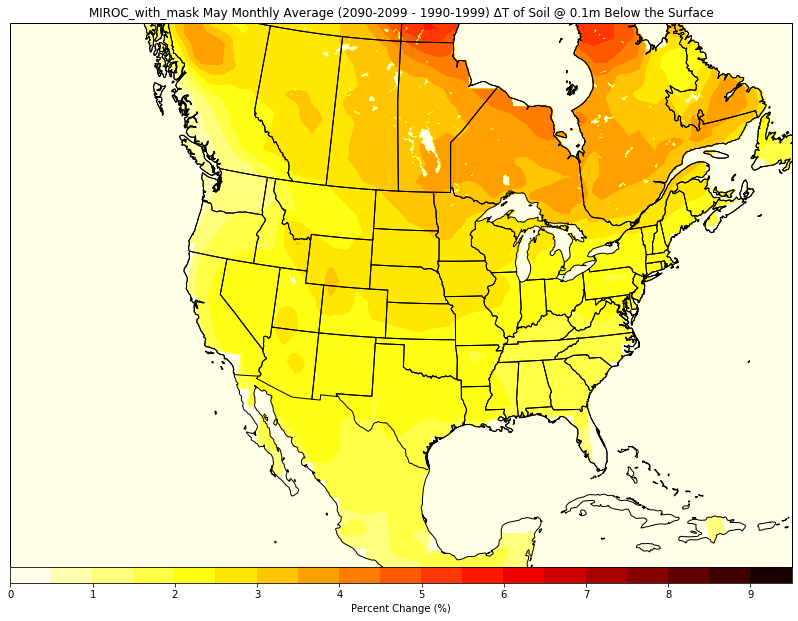

In [11]:
surface_plot(miroc_ds, 'MIROC_with_mask')

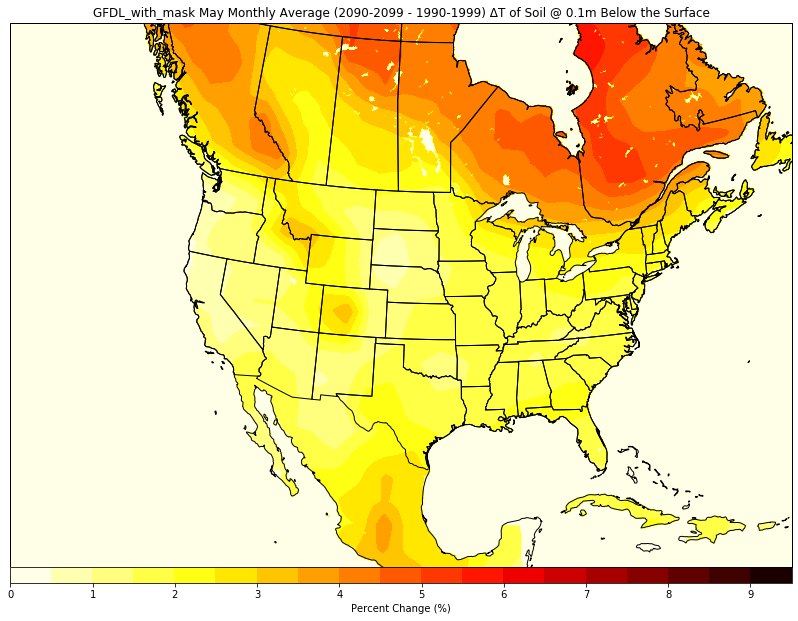

In [12]:
surface_plot(gfdl_ds, 'GFDL_with_mask')

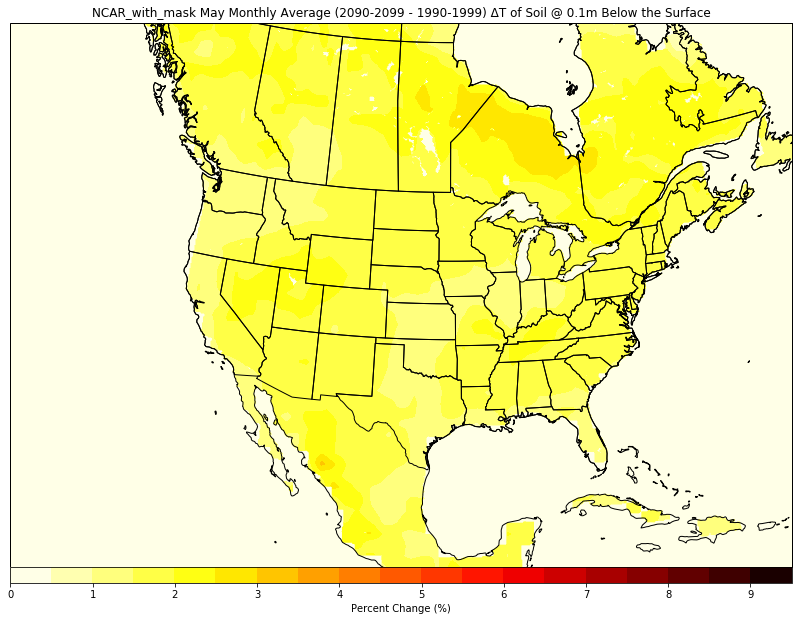

In [13]:
surface_plot(ncar_ds, 'NCAR_with_mask')

---
# Write to files


### MIROC

In [14]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    miroc_ds = miroc_ds.drop('crs')
except ValueError:
    None

miroc_ds.to_netcdf('../preliminary_netcdf/MIROC_soil_vars.nc')

### GFDL

In [15]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    gfdl_ds = gfdl_ds.drop('crs')
except ValueError:
    None

gfdl_ds.to_netcdf('../preliminary_netcdf/GFDL_soil_vars.nc')

### NCAR

In [16]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    ncar_ds = ncar_ds.drop('crs')
except ValueError:
    None
ncar_ds.to_netcdf('../preliminary_netcdf/NCAR_soil_vars.nc')